In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ardl import ARDL, ardl_select_order, UECM
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report
from arch import arch_model
# import warnings
import fredapi as fa
from datetime import date
from twelvedata import TDClient
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import re
import os
os.chdir('/Users/fulinq/Documents/KMITL/FinancialEngineering/Y4/Y4T1/PROJECT/ARDL-ECM/Code')

In [2]:
fred = fa.Fred(api_key='c948956426006ca126a2dd3bd1f07cee')
td = TDClient(apikey='aa61c51218c248698467af34d09b9d46')

## Data Retrieve ##

In [3]:
# 1. Fetch First Batch (Latest 5000 records)
ts1 = td.time_series(
    symbol="XAU/USD",
    interval="1day",
    outputsize=5000,
    timezone="Asia/Bangkok"
)
df1 = ts1.as_pandas()

# Get the oldest date from batch 1 to serve as the end_date for batch 2
oldest_date = df1.index.min()
time.sleep(10) # Wait slightly to respect API rate limits

# 2. Fetch Second Batch (Previous 5000 records)
ts2 = td.time_series(
    symbol="XAU/USD",
    interval="1day",
    outputsize=5000,
    timezone="Asia/Bangkok",
    end_date=oldest_date
)
df2 = ts2.as_pandas()

# 3. Concatenate DataFrames
gold = pd.concat([df1, df2])
all_gold = gold.copy()
all_gold.to_csv('all_gold_data.csv')

# Select only close price
gold = gold[['close']].copy()

# Rename column to 'Gold'
gold.rename(columns={'close': 'Gold'}, inplace=True)

# Convert index to Datetime and remove Timezone (Crucial for merging with FRED)
gold.index = pd.to_datetime(gold.index).tz_localize(None)

# Sort index (Oldest -> Newest)
gold = gold.sort_index()

# Remove duplicate indices (in case of overlap between batches)
gold = gold[~gold.index.duplicated(keep='first')]

# Check and Fill NA
print(f'NaN value before: {gold.isna().sum().sum()}')
gold = gold.ffill()
print(f'NaN value after: {gold.isna().sum().sum()}')

gold

NaN value before: 0
NaN value after: 0


,Gold
datetime,
1987-12-31,485.85001
1988-01-04,480.76001
1988-01-05,480.76001
1988-01-06,483.28000
1988-01-07,481.31000
...,...
2026-01-28,5327.17903
2026-01-29,5310.53137
2026-01-30,4940.66781


In [4]:
dollar_index = fred.get_series('DTWEXBGS') #nominal dollar index
dollar_index.rename('Dollar Index', inplace=True)
dollar_index.index = pd.to_datetime(dollar_index.index) 

# month_ends = pd.date_range(start=dollar_index.index.min(), end=dollar_index.index.max(), freq='M')
# new_index = dollar_index.index.union(month_ends)
# dollar_index = dollar_index.reindex(new_index)

print(f'NaN value : {dollar_index.isna().sum()}')
dollar_index = dollar_index.ffill()
print(f'NaN value after ffill: {dollar_index.isna().sum()}')
dollar_index

NaN value : 207
NaN value after ffill: 0


2006-01-02    101.4155
2006-01-03    100.7558
2006-01-04    100.2288
2006-01-05    100.2992
2006-01-06    100.0241
                ...   
2026-01-19    120.4478
2026-01-20    119.8255
2026-01-21    119.7240
2026-01-22    119.5823
2026-01-23    119.2855
Name: Dollar Index, Length: 5235, dtype: float64

In [5]:
ppi = fred.get_series('PPIACO') #PPI all commodities
ppi.rename('PPI', inplace=True)
ppi.index = pd.to_datetime(ppi.index)
print(f'NaN value : {ppi.isna().sum()}')
ppi = ppi.ffill()
print(f'NaN value after ffill: {ppi.isna().sum()}')
ppi

NaN value : 0
NaN value after ffill: 0


1913-01-01     12.100
1913-02-01     12.000
1913-03-01     12.000
1913-04-01     12.000
1913-05-01     11.900
               ...   
2025-08-01    262.110
2025-09-01    262.094
2025-10-01    260.724
2025-11-01    261.358
2025-12-01    260.686
Name: PPI, Length: 1356, dtype: float64

In [6]:
fed_fund = fred.get_series('FEDFUNDS') #federal fund rate
fed_fund.rename('Federal Fund Rate', inplace=True)
fed_fund.index = pd.to_datetime(fed_fund.index)
fed_fund = fed_fund.mul(0.01)

# month_ends = pd.date_range(start=fed_fund.index.min(), end=fed_fund.index.max(), freq='M')
# new_index = fed_fund.index.union(month_ends)
# fed_fund = fed_fund.reindex(new_index)

print(f'NaN value before processing: {fed_fund.isna().sum()}')
fed_fund = fed_fund.ffill()
fed_fund.rename('Federal Fund Rate', inplace=True) # Re-apply the name after reindexing
print(f'NaN value after processing: {fed_fund.isna().sum()}')
fed_fund

NaN value before processing: 0
NaN value after processing: 0


1954-07-01    0.0080
1954-08-01    0.0122
1954-09-01    0.0107
1954-10-01    0.0085
1954-11-01    0.0083
               ...  
2025-08-01    0.0433
2025-09-01    0.0422
2025-10-01    0.0409
2025-11-01    0.0388
2025-12-01    0.0372
Name: Federal Fund Rate, Length: 858, dtype: float64

In [7]:
vix = fred.get_series('VIXCLS') #CBOE Volatility Index: VIX
vix.rename('VIX', inplace=True)
vix.index = pd.to_datetime(vix.index)
print(f'NaN value : {vix.isna().sum()}')
vix = vix.ffill()
print(f'NaN value after ffill: {vix.isna().sum()}')
vix

NaN value : 301
NaN value after ffill: 0


1990-01-02    17.24
1990-01-03    18.19
1990-01-04    19.22
1990-01-05    20.11
1990-01-08    20.26
              ...  
2026-01-23    16.09
2026-01-26    16.15
2026-01-27    16.35
2026-01-28    16.35
2026-01-29    16.88
Name: VIX, Length: 9413, dtype: float64

In [8]:
unemploy = fred.get_series('ICSA') #Initial Claims
unemploy.rename('ISCA', inplace=True)
unemploy.index = pd.to_datetime(unemploy.index)
print(f'NaN value : {unemploy.isna().sum()}')
unemploy = unemploy.ffill()
print(f'NaN value after ffill: {unemploy.isna().sum()})')
unemploy

NaN value : 0
NaN value after ffill: 0)


1967-01-07    208000.0
1967-01-14    207000.0
1967-01-21    217000.0
1967-01-28    204000.0
1967-02-04    216000.0
                ...   
2025-12-27    200000.0
2026-01-03    207000.0
2026-01-10    199000.0
2026-01-17    210000.0
2026-01-24    209000.0
Name: ISCA, Length: 3082, dtype: float64

In [9]:
ip = fred.get_series('INDPRO') #Industrial Production Index
ip.rename('Industrial Production', inplace=True)
ip.index = pd.to_datetime(ip.index)
print(f'NaN value : {ip.isna().sum()}')
ip = ip.ffill()
print(f'NaN value after ffill: {ip.isna().sum()}')
ip

NaN value : 0
NaN value after ffill: 0


1919-01-01      4.8739
1919-02-01      4.6585
1919-03-01      4.5238
1919-04-01      4.6046
1919-05-01      4.6315
                ...   
2025-08-01    101.5867
2025-09-01    101.7779
2025-10-01    101.5163
2025-11-01    101.9528
2025-12-01    102.3250
Name: Industrial Production, Length: 1284, dtype: float64

In [10]:
fed_balance = fred.get_series('WALCL') #Federal Reserve Total Assets
fed_balance.rename('Fed Balance Sheet', inplace=True)
fed_balance.index = pd.to_datetime(fed_balance.index)
print(f'NaN value : {fed_balance.isna().sum()}')
fed_balance = fed_balance.ffill()
print(f'NaN value after ffill: {fed_balance.isna().sum()}')
fed_balance

NaN value : 0
NaN value after ffill: 0


2002-12-18     719542.0
2002-12-25     732059.0
2003-01-01     730994.0
2003-01-08     723762.0
2003-01-15     720074.0
                ...    
2025-12-31    6640618.0
2026-01-07    6573602.0
2026-01-14    6581700.0
2026-01-21    6584580.0
2026-01-28    6587568.0
Name: Fed Balance Sheet, Length: 1207, dtype: float64

In [11]:
# 1. organize data
realtime_data = {
    'gold': gold,
    'dollar_index': dollar_index,
    'vix': vix,
    'fed_rate': fed_fund,
    'fed_balance': fed_balance,
    'labor_claims': unemploy
}

lagged_data = {
    'ip': ip,
    'ppi': ppi
}

# 2. resample & rename
monthly_dfs = []

# process real-time
for name, data in realtime_data.items():
    # FIX: force rename for both Series and DataFrame to match the key (lowercase)
    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0].to_frame(name)
    else:
        data = data.to_frame(name)
    
    if name in ['labor_claims', 'vix']:
        monthly_dfs.append(data.resample('M').mean())
    else:
        monthly_dfs.append(data.resample('M').last())

# process lagged
for name, data in lagged_data.items():
    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0].to_frame(name)
    else:
        data = data.to_frame(name)
    monthly_dfs.append(data.resample('M').last())

# 3. merge
df_final = pd.concat(monthly_dfs, axis=1)

# 4. handle lag (shift)
vars_to_shift = ['ip', 'ppi']
for col in vars_to_shift:
    df_final[col] = df_final[col].shift(1)

# 5. target variable
df_final['target_gold'] = df_final['gold'].shift(-1)

# 6. feature selection
features = [
    'gold', 'dollar_index', 'vix', 'fed_rate', 
    'fed_balance', 'labor_claims', 
    'ip', 'ppi'
]

df_model = df_final[features + ['target_gold']].dropna()

# check
print(f"data range: {df_model.index.min().date()} to {df_model.index.max().date()}")
print(df_model.columns)
df_model

data range: 2006-01-31 to 2025-12-31
Index(['gold', 'dollar_index', 'vix', 'fed_rate', 'fed_balance',
       'labor_claims', 'ip', 'ppi', 'target_gold'],
      dtype='object')


,gold,dollar_index,vix,fed_rate,fed_balance,labor_claims,ip,ppi,target_gold
2006-01-31,568.95001,99.4311,12.000909,0.0429,828901.0,295750.0,98.0452,163.000,561.75000
2006-02-28,561.75000,99.7695,12.448000,0.0449,840555.0,290750.0,98.1999,164.300,583.65002
2006-03-31,583.65002,100.5600,11.693913,0.0459,833675.0,301750.0,98.2413,161.800,654.50000
2006-04-30,654.50000,98.1412,11.874000,0.0479,844572.0,303600.0,98.4628,162.200,643.70001
2006-05-31,643.70001,97.7705,14.446087,0.0494,851580.0,332750.0,98.7618,164.300,613.09998
...,...,...,...,...,...,...,...,...,...
2025-08-31,3463.81000,120.6028,15.750000,0.0433,6603384.0,230000.0,101.8940,262.358,3869.18000
2025-09-30,3869.18000,120.5624,15.789091,0.0422,6608395.0,234750.0,101.5867,262.110,3995.65000
2025-10-31,3995.65000,121.7715,18.086522,0.0409,6587034.0,226750.0,101.7779,262.094,4216.34338
2025-11-30,4216.34338,121.4288,19.769500,0.0388,6552419.0,217600.0,101.5163,260.724,4311.26879


In [12]:
df_model.to_csv('gold_price_model_data.csv')

## Data Preparation ##

In [13]:
df_model = pd.read_csv('gold_price_model_data.csv', index_col=0, parse_dates=True)
df_model = df_model[df_model.index >= '2010-01-01']

In [14]:
vars_to_log = ['gold', 'dollar_index', 'vix', 'fed_balance', 'labor_claims', 'ip', 'ppi', 'target_gold']
for col in vars_to_log:
    df_model[f'ln_{col}'] = np.log(df_model[col])

model_vars = ['fed_rate'] + [f'ln_{c}' for c in vars_to_log]
df_ardl = df_model[model_vars].dropna()

df_ardl

,fed_rate,ln_gold,ln_dollar_index,ln_vix,ln_fed_balance,ln_labor_claims,ln_ip,ln_ppi,ln_target_gold
2010-01-31,0.0011,6.986151,4.540779,3.023463,14.625056,13.081125,4.481638,5.182345,7.017954
2010-02-28,0.0013,7.017954,4.539673,3.115713,14.642370,13.093449,4.492478,5.203457,7.015533
2010-03-31,0.0016,7.015533,4.531510,2.877365,14.651524,13.061020,4.496224,5.198497,7.072634
2010-04-30,0.0020,7.072634,4.530902,2.857984,14.661581,13.058358,4.503058,5.211124,7.103495
2010-05-31,0.0020,7.103495,4.567533,3.463740,14.663112,13.037677,4.506444,5.217107,7.124760
...,...,...,...,...,...,...,...,...,...
2025-08-31,0.0433,8.150124,4.792503,2.756840,15.703093,12.345835,4.623933,5.569710,8.260798
2025-09-30,0.0422,8.260798,4.792167,2.759319,15.703851,12.366276,4.620913,5.568764,8.292962
2025-10-31,0.0409,8.292962,4.802146,2.895167,15.700614,12.331603,4.622793,5.568703,8.346724
2025-11-30,0.0388,8.346724,4.799328,2.984140,15.695345,12.290414,4.620219,5.563462,8.368988


In [15]:
def run_adf_test(series, name):
    # Test at Level
    result = adfuller(series.dropna())
    p_value = result[1]
    
    if p_value <= 0.05:
        return f"I(0) - Stationary (p={p_value:.4f})"
    else:
        # ถ้า Level ไม่นิ่ง ให้ลอง Test แบบ Diff (First Difference)
        diff_result = adfuller(series.diff().dropna())
        diff_p_value = diff_result[1]
        
        if diff_p_value <= 0.05:
            return f"I(1) - Stationary at Diff (p={diff_p_value:.4f})"
        else:
            return f"I(2) or Higher (Non-Stationary) (p={diff_p_value:.4f})"

summary_data = []
for col in df_ardl.columns:
    status = run_adf_test(df_ardl[col], col)
    summary_data.append({'Variable': col, 'Status': status})

df_status = pd.DataFrame(summary_data)
df_status

,Variable,Status
0,fed_rate,I(1) - Stationary at Diff (p=0.0499)
1,ln_gold,I(1) - Stationary at Diff (p=0.0000)
2,ln_dollar_index,I(1) - Stationary at Diff (p=0.0003)
3,ln_vix,I(0) - Stationary (p=0.0001)
4,ln_fed_balance,I(1) - Stationary at Diff (p=0.0010)
5,ln_labor_claims,I(0) - Stationary (p=0.0211)
6,ln_ip,I(0) - Stationary (p=0.0099)
7,ln_ppi,I(1) - Stationary at Diff (p=0.0000)
8,ln_target_gold,I(1) - Stationary at Diff (p=0.0000)


In [16]:
X_cols = ['fed_rate', 'ln_gold', 'ln_dollar_index', 'ln_vix', 
          'ln_labor_claims', 'ln_ip', 'ln_ppi'
        # , 'ln_fed_balance'
          ]

X = df_ardl[X_cols].dropna()
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

,Variable,VIF
0,const,39018.902641
1,fed_rate,3.713619
2,ln_gold,3.459657
3,ln_dollar_index,2.124159
4,ln_vix,1.763181
5,ln_labor_claims,2.722754
6,ln_ip,2.217031
7,ln_ppi,4.826889


## Model 1 : Fix lag at 1 ##

In [17]:
y_col = 'ln_gold'
X_cols = ['fed_rate', 'ln_dollar_index', 'ln_vix', 
          'ln_labor_claims', 'ln_ip'
        , 'ln_ppi'
          ]

data_ardl = df_ardl[[y_col] + X_cols].dropna()

model_ardl = ARDL(data_ardl[y_col], lags=1, exog=data_ardl[X_cols], order=1)
res_ardl = model_ardl.fit()
res_ardl.summary()

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARDL Model Results                                 
=====================================================================================
Dep. Variable:                       ln_gold   No. Observations:                  192
Model:             ARDL(1, 1, 1, 1, 1, 1, 1)   Log Likelihood                 358.298
Method:                      Conditional MLE   S.D. of innovations              0.037
Date:                       Sun, 01 Feb 2026   AIC                           -686.596
Time:                               16:36:58   BIC                           -637.812
Sample:                           02-28-2010   HQIC                          -666.836
                                - 12-31-2025                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6196      0.655      0.946      0.346      -0.674       1.913
ln_gold.L1             0.9453      0.022     42.209      0.000       0.901       0.990
fed_rate.L0           -8.6706      3.036     -2.856      0.005     -14.663      -2.679
fed_rate.L1            9.1855      2.967      3.096      0.002       3.331      15.040
ln_dollar_index.L0    -1.3304      0.188     -7.091      0.000      -1.701      -0.960
ln_dollar_index.L1     1.3558      0.187      7.269      0.000       0.988       1.724
ln_vix.L0              0.0697      0.019      3.767      0.000       0.033       0.106
ln_vix.L1             -0.0433      0.018     -2.369      0.019      -0.079      -0.007
ln_labor_claims.L0    -0.0401      0.020     -2.022      0.045      -0.079      -0.001
ln_labor_claims.L1     0.0339      0.020      1.695      0.092      -0.006       0.073
ln_ip.L0               0.0600      0.260      0.231      0.818      -0.452       0.572
ln_ip.L1              -0.2378      0.243     -0.979      0.329      -0.717       0.242
ln_ppi.L0              0.0385      0.317      0.121      0.904      -0.588       0.665
ln_ppi.L1              0.0526      0.329      0.160      0.873      -0.596       0.701
======================================================================================
"""

In [18]:
model_uecm = UECM(data_ardl[y_col], lags=1, exog=data_ardl[X_cols], order=1)
res_uecm = model_uecm.fit()
res_uecm.summary()

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  UECM Model Results                                 
=====================================================================================
Dep. Variable:                     D.ln_gold   No. Observations:                  192
Model:             UECM(1, 1, 1, 1, 1, 1, 1)   Log Likelihood                 358.298
Method:                      Conditional MLE   S.D. of innovations              7.372
Date:                       Sun, 01 Feb 2026   AIC                           -686.596
Time:                               16:36:58   BIC                           -637.812
Sample:                           02-28-2010   HQIC                          -666.836
                                - 12-31-2025                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6196      0.655      0.946      0.346      -0.674       1.913
ln_gold.L1              -0.0547      0.022     -2.441      0.016      -0.099      -0.010
fed_rate.L1              0.5149      0.347      1.483      0.140      -0.170       1.200
ln_dollar_index.L1       0.0254      0.038      0.673      0.502      -0.049       0.100
ln_vix.L1                0.0264      0.015      1.765      0.079      -0.003       0.056
ln_labor_claims.L1      -0.0062      0.012     -0.535      0.593      -0.029       0.017
ln_ip.L1                -0.1778      0.146     -1.215      0.226      -0.467       0.111
ln_ppi.L1                0.0911      0.062      1.469      0.144      -0.031       0.214
D.fed_rate.L0           -8.6706      3.036     -2.856      0.005     -14.663      -2.679
D.ln_dollar_index.L0    -1.3304      0.188     -7.091      0.000      -1.701      -0.960
D.ln_vix.L0              0.0697      0.019      3.767      0.000       0.033       0.106
D.ln_labor_claims.L0    -0.0401      0.020     -2.022      0.045      -0.079      -0.001
D.ln_ip.L0               0.0600      0.260      0.231      0.818      -0.452       0.572
D.ln_ppi.L0              0.0385      0.317      0.121      0.904      -0.588       0.665
========================================================================================
"""

In [19]:
ect_coeff = res_uecm.params[f'{y_col}.L1']
ect_pvalue = res_uecm.pvalues[f'{y_col}.L1']
print(f"\nค่า ECT Coefficient: {ect_coeff:.5f}")
print(f"P-value: {ect_pvalue:.5f}")

if ect_coeff < 0 and ect_pvalue < 0.05:
    print("✅ pass: significant and negative ECT (having long-term equilibrium adjustment)")
else:
    print("❌ fail: ECT is positive or not significant (try reducing lag or check variables again)")


ค่า ECT Coefficient: -0.05467
P-value: 0.01563
✅ pass: significant and negative ECT (having long-term equilibrium adjustment)


## Model 2 : AIC Individual Selection ##

In [20]:
y_col = 'ln_gold'
X_cols = ['fed_rate', 'ln_dollar_index', 'ln_vix', 
          'ln_labor_claims', 'ln_ip'
        , 'ln_ppi'
          ]

data_ardl = df_ardl[[y_col] + X_cols].dropna()

custom_max_order = {
    'fed_rate': 6,
    'ln_dollar_index': 5,
    'ln_vix': 3,
    'ln_labor_claims': 6,
    'ln_ip': 4,
    'ln_ppi': 4
}

sel_res = ardl_select_order(
    data_ardl[y_col], 
    maxlag=6, 
    exog=data_ardl[X_cols], 
    maxorder=custom_max_order,
    ic='aic'
)

print(f"Best AR Lags: {sel_res.ar_lags}")
print(f"Best DL Orders: {sel_res.dl_lags}")

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Best AR Lags: [1, 2, 3, 4]
Best DL Orders: {'fed_rate': [0, 1], 'ln_dollar_index': [0, 1, 2], 'ln_vix': [0, 1], 'ln_labor_claims': [0, 1, 2, 3, 4, 5]}


In [21]:
ar_lag = max(sel_res.ar_lags) if isinstance(sel_res.ar_lags, list) else sel_res.ar_lags
dl_lags = {k: (max(v) if isinstance(v, list) else v) for k, v in sel_res.dl_lags.items()}

print(f"\n--- 2. ARDL Levels Analysis & Bounds Test ---")
model_ardl = ARDL(
    data_ardl[y_col], 
    lags=ar_lag, 
    exog=data_ardl[X_cols], 
    order=dl_lags
)
res_ardl = model_ardl.fit()
res_ardl.summary()


--- 2. ARDL Levels Analysis & Bounds Test ---


/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ln_ppi, ln_ip.
  return _format_order(self.data.orig_exog, order, self._causal)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARDL Model Results                              
===============================================================================
Dep. Variable:                 ln_gold   No. Observations:                  192
Model:             ARDL(4, 1, 2, 1, 5)   Log Likelihood                 364.543
Method:                Conditional MLE   S.D. of innovations              0.035
Date:                 Sun, 01 Feb 2026   AIC                           -691.087
Time:                         16:37:45   BIC                           -629.594
Sample:                     06-30-2010   HQIC                          -666.172
                          - 12-31-2025                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2547      0.201      1.269      0.206      -0.142       0.651
ln_gold.L1             0.7402      0.073     10.178      0.000       0.597       0.884
ln_gold.L2             0.1234      0.089      1.390      0.166      -0.052       0.299
ln_gold.L3             0.0058      0.084      0.070      0.945      -0.159       0.171
ln_gold.L4             0.1221      0.064      1.908      0.058      -0.004       0.249
fed_rate.L0           -9.2553      2.571     -3.600      0.000     -14.330      -4.181
fed_rate.L1            9.6884      2.579      3.757      0.000       4.598      14.779
ln_dollar_index.L0    -1.4147      0.179     -7.923      0.000      -1.767      -1.062
ln_dollar_index.L1     0.8329      0.251      3.320      0.001       0.338       1.328
ln_dollar_index.L2     0.5870      0.194      3.032      0.003       0.205       0.969
ln_vix.L0              0.0915      0.018      4.986      0.000       0.055       0.128
ln_vix.L1             -0.0408      0.018     -2.229      0.027      -0.077      -0.005
ln_labor_claims.L0    -0.0602      0.020     -3.045      0.003      -0.099      -0.021
ln_labor_claims.L1     0.0692      0.026      2.635      0.009       0.017       0.121
ln_labor_claims.L2    -0.0347      0.026     -1.333      0.184      -0.086       0.017
ln_labor_claims.L3     0.0230      0.025      0.912      0.363      -0.027       0.073
ln_labor_claims.L4     0.0145      0.024      0.610      0.543      -0.032       0.061
ln_labor_claims.L5    -0.0399      0.015     -2.593      0.010      -0.070      -0.010
======================================================================================
"""

In [22]:
model_uecm = UECM(
    data_ardl[y_col], 
    lags=ar_lag, 
    exog=data_ardl[X_cols], 
    order=dl_lags
)
res_uecm = model_uecm.fit()

ect_coef = res_uecm.params[f'{y_col}.L1']
ect_pval = res_uecm.pvalues[f'{y_col}.L1']

print(f"\n*** FINAL CHECK ***")
print(f"ECT Coefficient: {ect_coef:.5f}")
print(f"P-value:         {ect_pval:.5f}")

if ect_coef < 0 and ect_pval < 0.05:
    print("✅ Model is Valid: Correct adjustment speed")
else:
    print("❌ Model Issue: ECT is positive or insignificant")
    
res_uecm.summary()


*** FINAL CHECK ***
ECT Coefficient: -0.00842
P-value:         0.59068
❌ Model Issue: ECT is positive or insignificant


/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ln_ppi, ln_ip.
  return _format_order(self.data.orig_exog, order, self._causal)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               UECM Model Results                              
===============================================================================
Dep. Variable:               D.ln_gold   No. Observations:                  192
Model:             UECM(4, 1, 2, 1, 5)   Log Likelihood                 364.543
Method:                Conditional MLE   S.D. of innovations              7.359
Date:                 Sun, 01 Feb 2026   AIC                           -691.087
Time:                         16:37:45   BIC                           -629.594
Sample:                     06-30-2010   HQIC                          -666.172
                          - 12-31-2025                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2547      0.201      1.269      0.206      -0.142       0.651
ln_gold.L1              -0.0084      0.016     -0.539      0.591      -0.039       0.022
fed_rate.L1              0.4331      0.299      1.447      0.150      -0.158       1.024
ln_dollar_index.L1       0.0052      0.032      0.163      0.871      -0.058       0.068
ln_vix.L1                0.0507      0.014      3.634      0.000       0.023       0.078
ln_labor_claims.L1      -0.0280      0.011     -2.585      0.011      -0.049      -0.007
D.ln_gold.L1            -0.2514      0.073     -3.452      0.001      -0.395      -0.108
D.ln_gold.L2            -0.1280      0.065     -1.969      0.051      -0.256       0.000
D.ln_gold.L3            -0.1221      0.064     -1.908      0.058      -0.249       0.004
D.fed_rate.L0           -9.2553      2.571     -3.600      0.000     -14.330      -4.181
D.ln_dollar_index.L0    -1.4147      0.179     -7.923      0.000      -1.767      -1.062
D.ln_dollar_index.L1    -0.5870      0.194     -3.032      0.003      -0.969      -0.205
D.ln_vix.L0              0.0915      0.018      4.986      0.000       0.055       0.128
D.ln_labor_claims.L0    -0.0602      0.020     -3.045      0.003      -0.099      -0.021
D.ln_labor_claims.L1     0.0370      0.017      2.167      0.032       0.003       0.071
D.ln_labor_claims.L2     0.0024      0.017      0.141      0.888      -0.031       0.035
D.ln_labor_claims.L3     0.0254      0.015      1.645      0.102      -0.005       0.056
D.ln_labor_claims.L4     0.0399      0.015      2.593      0.010       0.010       0.070
========================================================================================
"""

## OLS Forecasting ##

In [23]:
data_model = pd.read_csv('gold_price_model_data.csv', index_col=0, parse_dates=True)
# data_model = data_model[data_model.index <= '2025-12-01']
data_model

,gold,dollar_index,vix,fed_rate,fed_balance,labor_claims,ip,ppi,target_gold
2006-01-31,568.95001,99.4311,12.000909,0.0429,828901.0,295750.0,98.0452,163.000,561.75000
2006-02-28,561.75000,99.7695,12.448000,0.0449,840555.0,290750.0,98.1999,164.300,583.65002
2006-03-31,583.65002,100.5600,11.693913,0.0459,833675.0,301750.0,98.2413,161.800,654.50000
2006-04-30,654.50000,98.1412,11.874000,0.0479,844572.0,303600.0,98.4628,162.200,643.70001
2006-05-31,643.70001,97.7705,14.446087,0.0494,851580.0,332750.0,98.7618,164.300,613.09998
...,...,...,...,...,...,...,...,...,...
2025-08-31,3463.81000,120.6028,15.750000,0.0433,6603384.0,230000.0,101.8940,262.358,3869.18000
2025-09-30,3869.18000,120.5624,15.789091,0.0422,6608395.0,234750.0,101.5867,262.110,3995.65000
2025-10-31,3995.65000,121.7715,18.086522,0.0409,6587034.0,226750.0,101.7779,262.094,4216.34338
2025-11-30,4216.34338,121.4288,19.769500,0.0388,6552419.0,217600.0,101.5163,260.724,4311.26879


In [24]:
df_ret = pd.DataFrame()
cols_to_transform = ['gold', 'dollar_index', 'vix', 'labor_claims'] # ไม่เอา IP, PPI ตามแผน Core Model
for col in cols_to_transform:
    if col in data_model.columns:
        df_ret[f'{col}_ret'] = np.log(data_model[col]).diff()
if 'fed_rate' in data_model.columns:
    df_ret['fed_change'] = data_model['fed_rate'].diff()
    
df_ret.dropna(inplace=True)
df_ret

,gold_ret,dollar_index_ret,vix_ret,labor_claims_ret,fed_change
2006-02-28,-0.012736,0.003398,0.036578,-0.017051,0.0020
2006-03-31,0.038245,0.007892,-0.062492,0.037135,0.0010
2006-04-30,0.114570,-0.024347,0.015283,0.006112,0.0020
2006-05-31,-0.016639,-0.003784,0.196072,0.091680,0.0015
2006-06-30,-0.048705,0.004875,0.157992,-0.085442,0.0005
...,...,...,...,...,...
2025-08-31,0.048625,-0.012410,-0.039300,0.038786,0.0000
2025-09-30,0.110673,-0.000335,0.002479,0.020442,-0.0011
2025-10-31,0.032164,0.009979,0.135848,-0.034673,-0.0013
2025-11-30,0.053762,-0.002818,0.088973,-0.041190,-0.0021


<Figure size 1000x400 with 0 Axes>

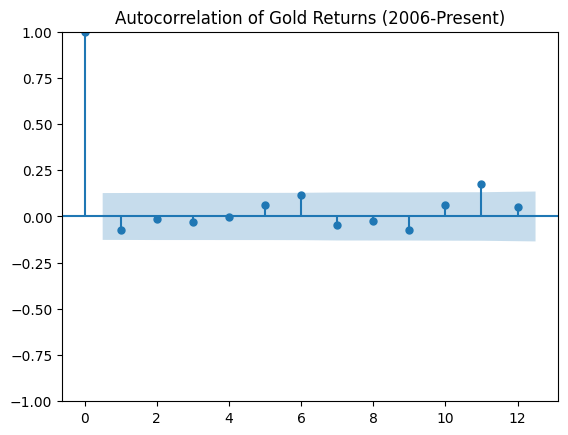

In [25]:
# 2. ACF Analysis
plt.figure(figsize=(10, 4))
plot_acf(df_ret['gold_ret'], lags=12, alpha=0.05)
plt.title('Autocorrelation of Gold Returns (2006-Present)')
plt.show()

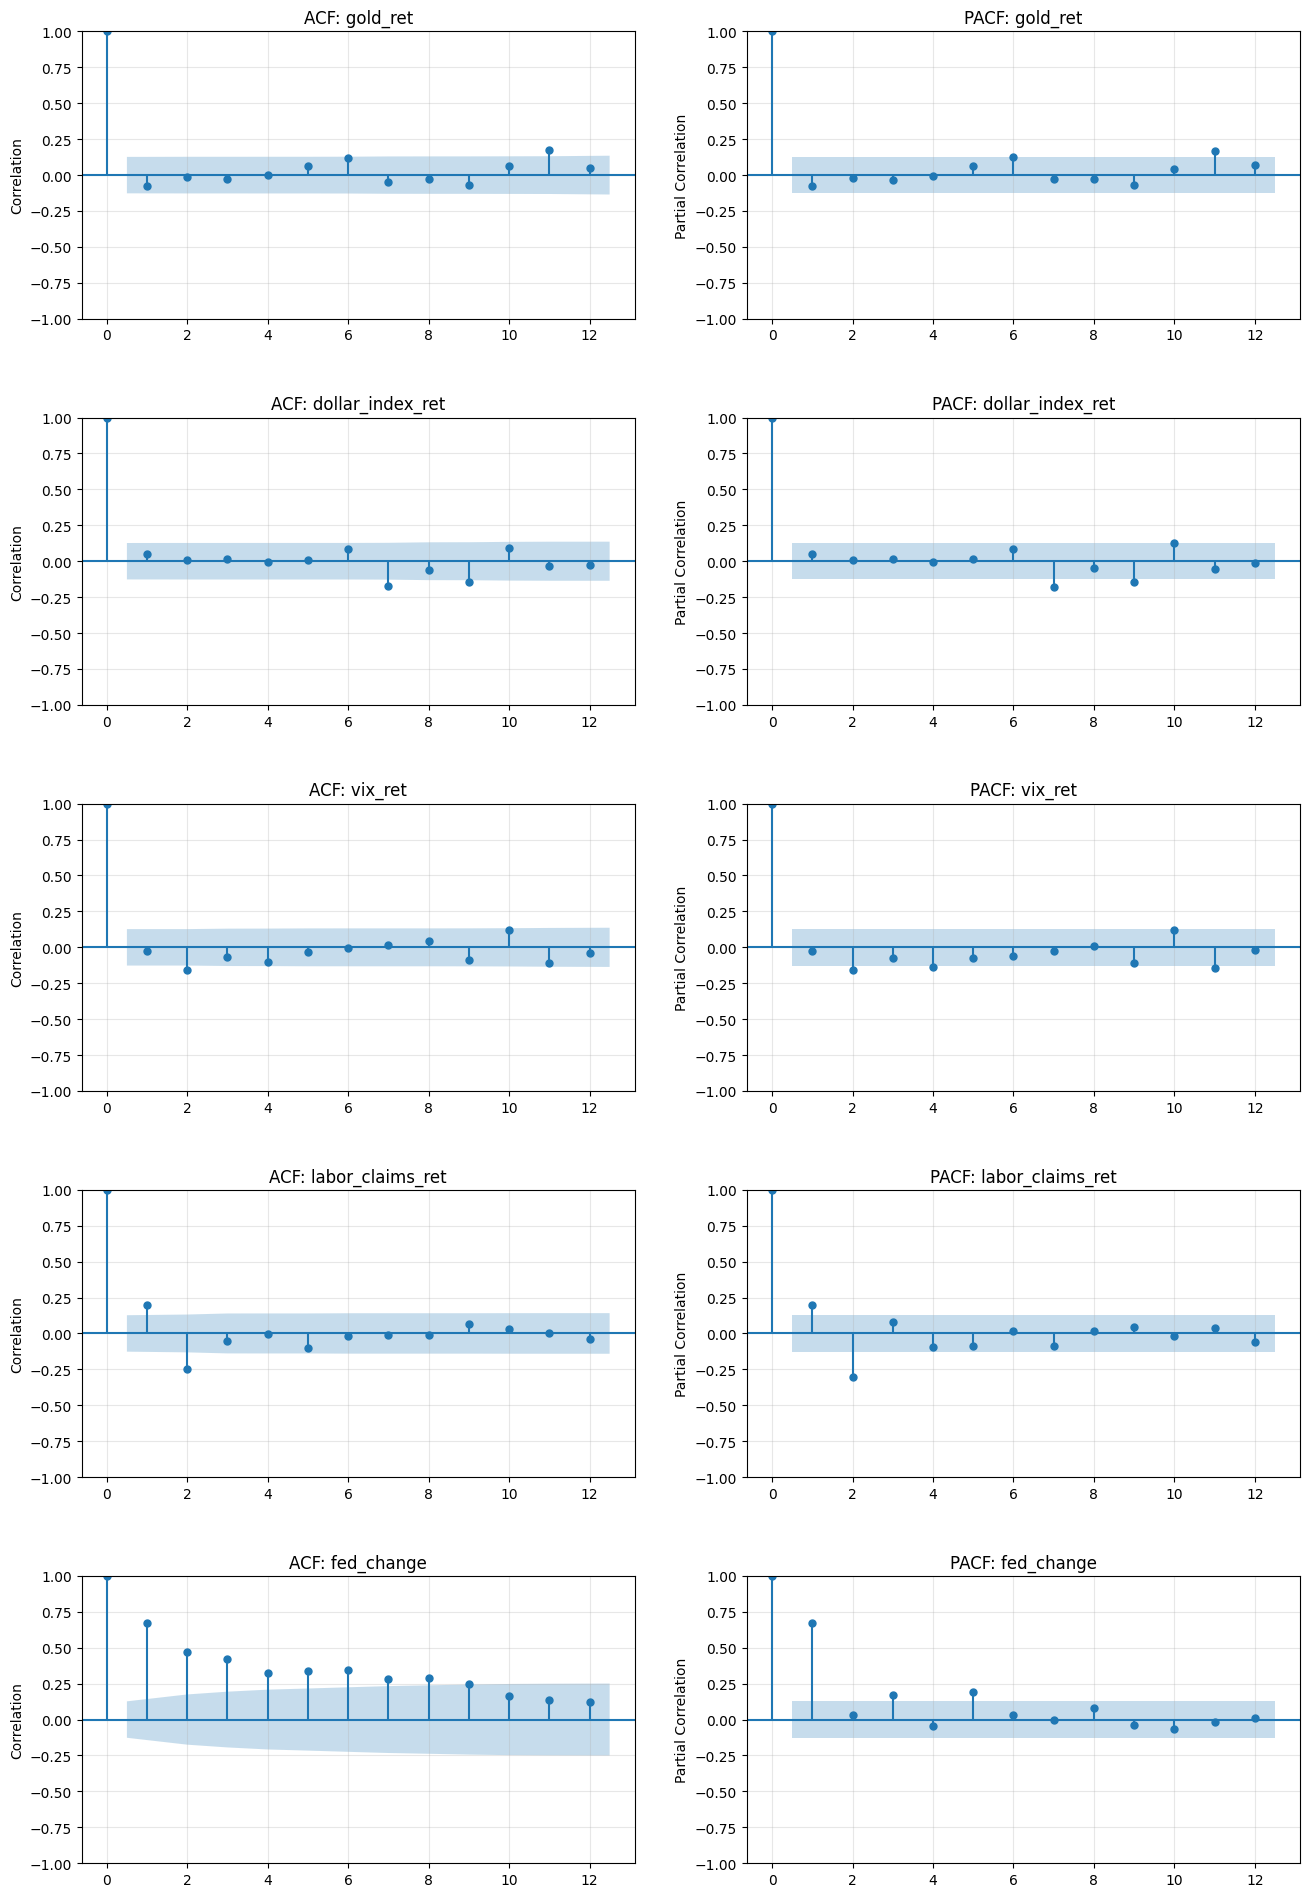

In [26]:
def plot_all_variables_lags(df, lags=12):
    num_cols = df.select_dtypes(include=['number']).columns
    n_vars = len(num_cols)
    
    fig, axes = plt.subplots(nrows=n_vars, ncols=2, figsize=(14, 4 * n_vars))
    
    plt.tight_layout(pad=5.0)
    
    for i, col in enumerate(num_cols):
        plot_acf(df[col].dropna(), lags=lags, ax=axes[i, 0], alpha=0.05)
        axes[i, 0].set_title(f"ACF: {col}")
        axes[i, 0].set_ylabel("Correlation")
        axes[i, 0].grid(True, alpha=0.3)

        plot_pacf(df[col].dropna(), lags=lags, ax=axes[i, 1], alpha=0.05, method='ywm')
        axes[i, 1].set_title(f"PACF: {col}")
        axes[i, 1].set_ylabel("Partial Correlation")
        axes[i, 1].grid(True, alpha=0.3)

    plt.show()
    
plot_all_variables_lags(df_ret, lags=12)

In [27]:
df_lag = df_ret.copy()
feature_cols = df_ret.columns.tolist()

for col in feature_cols:
    df_lag[f'L1_{col}'] = df_lag[col].shift(1)

df_lag.dropna(inplace=True)
df_lag

,gold_ret,dollar_index_ret,vix_ret,labor_claims_ret,fed_change,L1_gold_ret,L1_dollar_index_ret,L1_vix_ret,L1_labor_claims_ret,L1_fed_change
2006-03-31,0.038245,0.007892,-0.062492,0.037135,0.0010,-0.012736,0.003398,0.036578,-0.017051,0.0020
2006-04-30,0.114570,-0.024347,0.015283,0.006112,0.0020,0.038245,0.007892,-0.062492,0.037135,0.0010
2006-05-31,-0.016639,-0.003784,0.196072,0.091680,0.0015,0.114570,-0.024347,0.015283,0.006112,0.0020
2006-06-30,-0.048705,0.004875,0.157992,-0.085442,0.0005,-0.016639,-0.003784,0.196072,0.091680,0.0015
2006-07-31,0.034435,-0.002535,-0.105962,0.042614,0.0025,-0.048705,0.004875,0.157992,-0.085442,0.0005
...,...,...,...,...,...,...,...,...,...,...
2025-08-31,0.048625,-0.012410,-0.039300,0.038786,0.0000,-0.001060,0.018864,-0.116391,-0.086540,0.0000
2025-09-30,0.110673,-0.000335,0.002479,0.020442,-0.0011,0.048625,-0.012410,-0.039300,0.038786,0.0000
2025-10-31,0.032164,0.009979,0.135848,-0.034673,-0.0013,0.110673,-0.000335,0.002479,0.020442,-0.0011
2025-11-30,0.053762,-0.002818,0.088973,-0.041190,-0.0021,0.032164,0.009979,0.135848,-0.034673,-0.0013


In [28]:
y = df_lag['gold_ret']
X_candidates = df_lag[[c for c in df_lag.columns if 'L1_' in c]]
X_candidates = sm.add_constant(X_candidates)

# --- Stepwise AIC Selection (หาโมเดลที่ดีที่สุด) ---
best_aic = float('inf')
best_vars = ['const']
candidate_vars = X_candidates.columns.tolist()
candidate_vars.remove('const')

print("\n--- Starting AIC Variable Selection ---")
while True:
    step_best_aic = best_aic
    step_best_var = None
    
    for var in candidate_vars:
        if var in best_vars: continue
        
        temp_vars = best_vars + [var]
        try:
            model = sm.OLS(y, X_candidates[temp_vars]).fit()
            if model.aic < step_best_aic:
                step_best_aic = model.aic
                step_best_var = var
        except:
            continue
            
    if step_best_var:
        best_vars.append(step_best_var)
        best_aic = step_best_aic
        print(f"Added: {step_best_var:<25} | New AIC: {best_aic:.4f}")
    else:
        break

print(f"\n✅ Final Best Variables: {best_vars}")

# --- Fit Final Model ---
final_model = sm.OLS(y, X_candidates[best_vars]).fit()
final_model.summary()


--- Starting AIC Variable Selection ---
Added: L1_fed_change             | New AIC: -767.1253

✅ Final Best Variables: ['const', 'L1_fed_change']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               gold_ret   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.613
Date:                Sun, 01 Feb 2026   Prob (F-statistic):              0.107
Time:                        16:37:46   Log-Likelihood:                 385.56
No. Observations:                 238   AIC:                            -767.1
Df Residuals:                     236   BIC:                            -760.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0085      0.003      2.731      0.007       0.002       0.015
L1_fed_change    -2.9061      1.798     -1.617      0.107      -6.448       0.636
==============================================================================
Omnibus:                        7.174   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                8.596
Skew:                          -0.255   Prob(JB):                       0.0136
Kurtosis:                       3.779   Cond. No.                         577.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
# 5. FORECAST NEXT MONTH

last_row = X_candidates.iloc[[-1]][best_vars]
pred_log_return = final_model.predict(last_row).item()

# แปลงกลับเป็นราคา (Price)
last_actual_price = data_model['gold'].iloc[-1]
forecast_price = last_actual_price * np.exp(pred_log_return)

print("\n" + "="*40)
print("GOLD PRICE FORECAST RESULT")
print("="*40)
print(f"Current Price:      {last_actual_price:,.2f}")
print(f"Predicted Return:   {pred_log_return:.4%} (Month-on-Month)")
print(f"Forecast Price:     {forecast_price:,.2f}")
print("="*40)


GOLD PRICE FORECAST RESULT
Current Price:      4,311.27
Predicted Return:   1.4616% (Month-on-Month)
Forecast Price:     4,374.74


In [30]:
# ARCH/GARCH Residual Analysis
X_lag = y.shift(1).dropna()
y_aligned = y.loc[X_lag.index]
X_aligned = sm.add_constant(X_lag)


model_ols_simple = sm.OLS(y_aligned, X_aligned).fit()
residuals = model_ols_simple.resid

lm_test = het_arch(residuals)
print(f"--- Engle's ARCH Test ---")
print(f"LM Statistic: {lm_test[0]:.4f}")
print(f"P-value:      {lm_test[1]:.4f}")

if lm_test[1] < 0.05:
    print("✅ พบความผันผวนแบบกระจุกตัว (Volatility Clustering)")
    print("👉 'ควรใช้ GARCH' มาช่วยจัดการความเสี่ยง")
    
    print("\n--- Running GARCH(1,1) Model ---")
    
    # GARCH Model (ใช้ y เดิมคูณ 100 เพื่อให้ตัวเลขสวยขึ้น/Optimize ง่ายขึ้น)
    # หมายเหตุ: การคูณ 100 เปลี่ยนหน่วยเป็น % Return
    garch_model = arch_model(y_aligned * 100, vol='Garch', p=1, q=1, mean='Constant', dist='Normal')
    res_garch = garch_model.fit(update_freq=5, disp='off')
    
    print(res_garch.summary())
    
    # Plot Volatility
    plt.figure(figsize=(10,4))
    plt.plot(res_garch.conditional_volatility, color='orange', label='GARCH Volatility')
    plt.title('Gold Price Volatility (Risk) over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("❌ no ARCH Effect (constant variance)")
    print("👉 OLS is enough, GARCH has no need")

--- Engle's ARCH Test ---
LM Statistic: 10.2788
P-value:      0.4164
❌ no ARCH Effect (constant variance)
👉 OLS is enough, GARCH has no need


## OLS walking-forward prediction

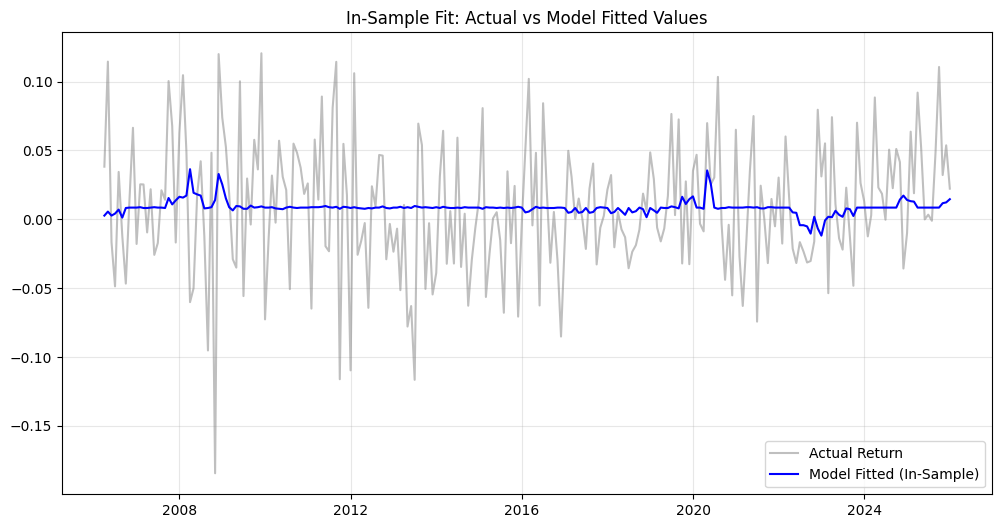

In [31]:
df_results = pd.DataFrame({
    'Actual': y,
    'Fitted': final_model.fittedvalues
}, index=y.index)

plt.figure(figsize=(12, 6))
plt.plot(df_results.index, df_results['Actual'], label='Actual Return', color='gray', alpha=0.5)
plt.plot(df_results.index, df_results['Fitted'], label='Model Fitted (In-Sample)', color='blue', linewidth=1.5)
plt.title('In-Sample Fit: Actual vs Model Fitted Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Start Walk-Forward Validation...
Training on first 166 months, Forecasting last 72 months.


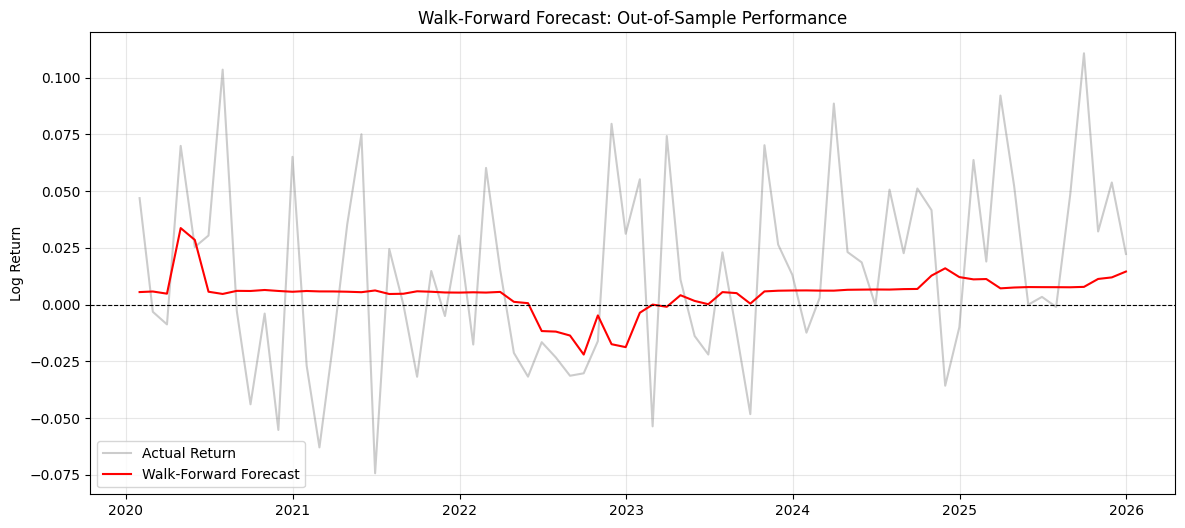

--------------------------------------------------
✅ Forecast Complete!
Range: 2020-01-31 -> 2025-12-31
Total Forecasted Months: 72
RMSE: 0.04172
MAE:  0.03261
--------------------------------------------------


In [32]:
n_total = len(y)
train_ratio = 0.7  # % train
n_train = int(n_total * train_ratio)

predictions = []
actuals = []
dates = []

print(f"Start Walk-Forward Validation...")
print(f"Training on first {n_train} months, Forecasting last {n_total - n_train} months.")

for i in range(n_train, n_total):
    X_train = X_candidates[best_vars].iloc[:i]
    y_train = y.iloc[:i]
    
    X_test_row = X_candidates[best_vars].iloc[[i]]
    y_test_value = y.iloc[i]
    
    model_wf = sm.OLS(y_train, X_train).fit()
    
    pred_value = model_wf.predict(X_test_row).item()
    
    predictions.append(pred_value)
    actuals.append(y_test_value)
    dates.append(y.index[i])
    
df_walk_forward = pd.DataFrame({
    'Actual': actuals,
    'Forecast': predictions
}, index=dates)

fig, ax = plt.subplots(figsize=(14, 6))

# Plot Returns
ax.plot(df_walk_forward.index, df_walk_forward['Actual'], label='Actual Return', color='gray', alpha=0.4)
ax.plot(df_walk_forward.index, df_walk_forward['Forecast'], label='Walk-Forward Forecast', color='red', linewidth=1.5)

# Highlight Zero Line (แยกโซนกำไร/ขาดทุน)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)

ax.set_title('Walk-Forward Forecast: Out-of-Sample Performance')
ax.set_ylabel('Log Return')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

rmse = np.sqrt(mean_squared_error(df_walk_forward['Actual'], df_walk_forward['Forecast']))
mae = mean_absolute_error(df_walk_forward['Actual'], df_walk_forward['Forecast'])
r2 = r2_score(df_walk_forward['Actual'], df_walk_forward['Forecast'])

print("-" * 50)
print(f"✅ Forecast Complete!")
print(f"Range: {df_walk_forward.index.min().date()} -> {df_walk_forward.index.max().date()}")
print(f"Total Forecasted Months: {len(df_walk_forward)}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE:  {mae:.5f}")
# print(f"R² (Out-of-Sample): {r2:.5f}") # อย่าตกใจถ้า R2 ติดลบ (เป็นปกติของ Time Series ระยะยาว)
print("-" * 50)

In [33]:
df_walk_forward

,Actual,Forecast
2020-01-31,0.046868,0.005488
2020-02-29,-0.003200,0.005739
2020-03-31,-0.008750,0.004785
2020-04-30,0.069886,0.033677
2020-05-31,0.025343,0.028458
...,...,...
2025-08-31,0.048625,0.007603
2025-09-30,0.110673,0.007779
2025-10-31,0.032164,0.011269
2025-11-30,0.053762,0.011955


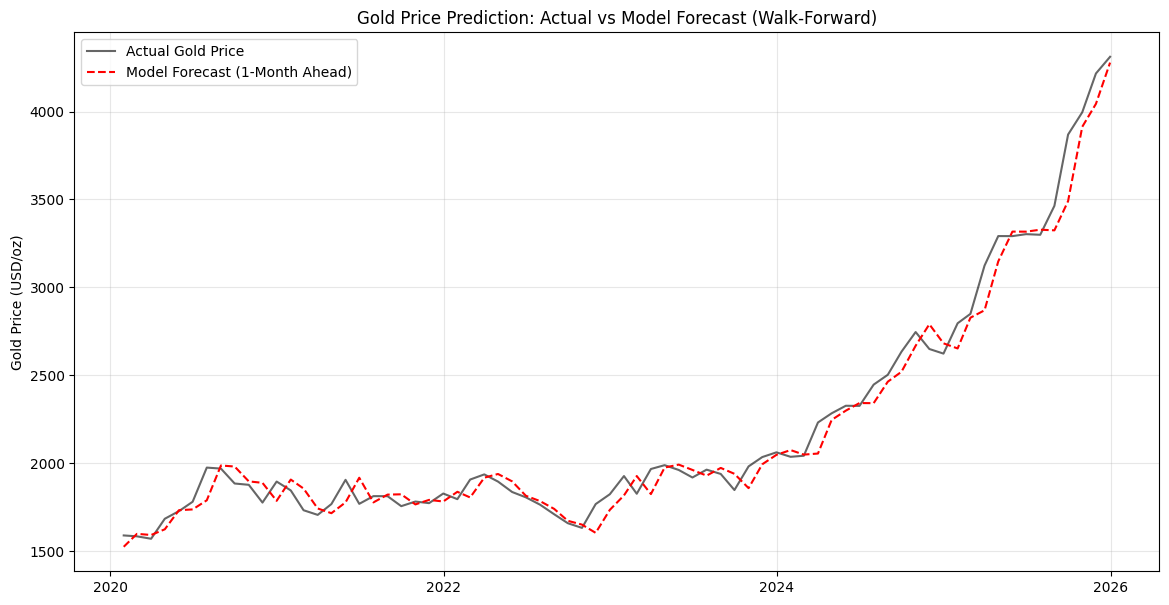

In [34]:
df_price_wf = pd.DataFrame(index=df_walk_forward.index)
df_price_wf['Actual_Price'] = data_model.loc[df_walk_forward.index, 'gold']

df_price_wf['Prev_Actual_Price'] = data_model['gold'].shift(1).loc[df_walk_forward.index]
# Price_t = Price_{t-1} * exp(Return_t)
df_price_wf['Forecast_Return'] = df_walk_forward['Forecast']
df_price_wf['Forecast_Price'] = df_price_wf['Prev_Actual_Price'] * np.exp(df_price_wf['Forecast_Return'])

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df_price_wf.index, df_price_wf['Actual_Price'], 
        label='Actual Gold Price', color='black', alpha=0.6, linewidth=1.5)
ax.plot(df_price_wf.index, df_price_wf['Forecast_Price'], 
        label='Model Forecast (1-Month Ahead)', color='red', linestyle='--', linewidth=1.5)

ax.set_title('Gold Price Prediction: Actual vs Model Forecast (Walk-Forward)')
ax.set_ylabel('Gold Price (USD/oz)')
ax.legend()
ax.grid(True, alpha=0.3)

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.YearLocator(2)) # โชว์ทุก 2 ปี
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

# # --- Error Metrics ---
# mae = np.mean(np.abs(df_price_wf['Forecast_Price'] - df_price_wf['Actual_Price']))
# rmse = np.sqrt(np.mean((df_price_wf['Forecast_Price'] - df_price_wf['Actual_Price'])**2))
# mape = np.mean(np.abs((df_price_wf['Actual_Price'] - df_price_wf['Forecast_Price']) / df_price_wf['Actual_Price'])) * 100

# print(f"--- Model Accuracy on Price Level ---")
# print(f"MAE (Mean Absolute Error):  ${mae:.2f}")
# print(f"RMSE (Root Mean Sq Error):  ${rmse:.2f}")
# print(f"MAPE (Mean Abs % Error):    {mape:.2f}%")

In [35]:
# Naive Forecast
df_price_wf['Naive_Forecast'] = df_price_wf['Prev_Actual_Price']

# Naive Error
mae_naive = np.mean(np.abs(df_price_wf['Naive_Forecast'] - df_price_wf['Actual_Price']))
rmse_naive = np.sqrt(np.mean((df_price_wf['Naive_Forecast'] - df_price_wf['Actual_Price'])**2))

# OLS Error
mae_model = np.mean(np.abs(df_price_wf['Forecast_Price'] - df_price_wf['Actual_Price']))
rmse_model = np.sqrt(np.mean((df_price_wf['Forecast_Price'] - df_price_wf['Actual_Price'])**2))

print("="*40)
print("   OLS MODEL vs NAIVE BASELINE COMPARISON   ")
print("="*40)
print(f"1. Naive MAE (Error):  ${mae_naive:.2f}")
print(f"2. Model MAE (Error):  ${mae_model:.2f}")
print("-" * 40)

if mae_model < mae_naive:
    improvement = (1 - mae_model / mae_naive) * 100
    print(f"✅ OLS is outperforming Naive by {improvement:.2f}%")
else:
    print(f"❌ OLS is underperforming Naive")

   OLS MODEL vs NAIVE BASELINE COMPARISON   
1. Naive MAE (Error):  $77.28
2. Model MAE (Error):  $71.66
----------------------------------------
✅ OLS is outperforming Naive by 7.27%


## Expanding Window

In [36]:
min_obs = 60
expanding_preds = []
expanding_actuals = []
expanding_dates = []

for i in range(min_obs, len(y)):
    X_train = X_candidates[best_vars].iloc[:i]
    y_train = y.iloc[:i]
    
    X_test_row = X_candidates[best_vars].iloc[[i]]
    y_test_value = y.iloc[i]
    
    model_expanding = sm.OLS(y_train, X_train).fit()
    pred_value = model_expanding.predict(X_test_row).item()
    
    expanding_preds.append(pred_value)
    expanding_actuals.append(y_test_value)
    expanding_dates.append(y.index[i])
    
df_expanding = pd.DataFrame({
    'Actual': expanding_actuals,
    'Forecast': expanding_preds
}, index=expanding_dates)

rmse = np.sqrt(mean_squared_error(df_expanding['Actual'], df_expanding['Forecast']))
mae = mean_absolute_error(df_expanding['Actual'], df_expanding['Forecast'])
r2 = r2_score(df_expanding['Actual'], df_expanding['Forecast'])

print("-" * 50)
print(f"✅ Forecast Complete!")
print(f"Range: {df_expanding.index.min().date()} -> {df_expanding.index.max().date()}")
print(f"Total Forecasted Months: {len(df_expanding)}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE:  {mae:.5f}")
# print(f"R² (Out-of-Sample): {r2:.5f}") # อย่าตกใจถ้า R2 ติดลบ (เป็นปกติของ Time Series ระยะยาว)
print("-" * 50)

--------------------------------------------------
✅ Forecast Complete!
Range: 2011-03-31 -> 2025-12-31
Total Forecasted Months: 178
RMSE: 0.04526
MAE:  0.03514
--------------------------------------------------


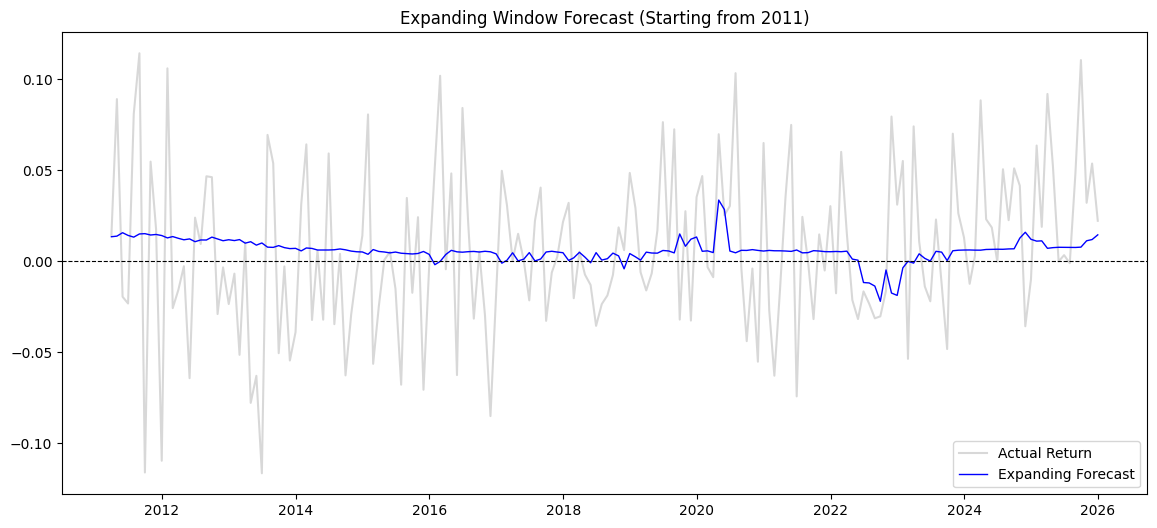

In [37]:
plt.figure(figsize=(14, 6))
plt.plot(df_expanding.index, df_expanding['Actual'], label='Actual Return', color='gray', alpha=0.3)
plt.plot(df_expanding.index, df_expanding['Forecast'], label='Expanding Forecast', color='blue', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title(f'Expanding Window Forecast (Starting from {df_expanding.index[0].year})')
plt.legend()
plt.show()

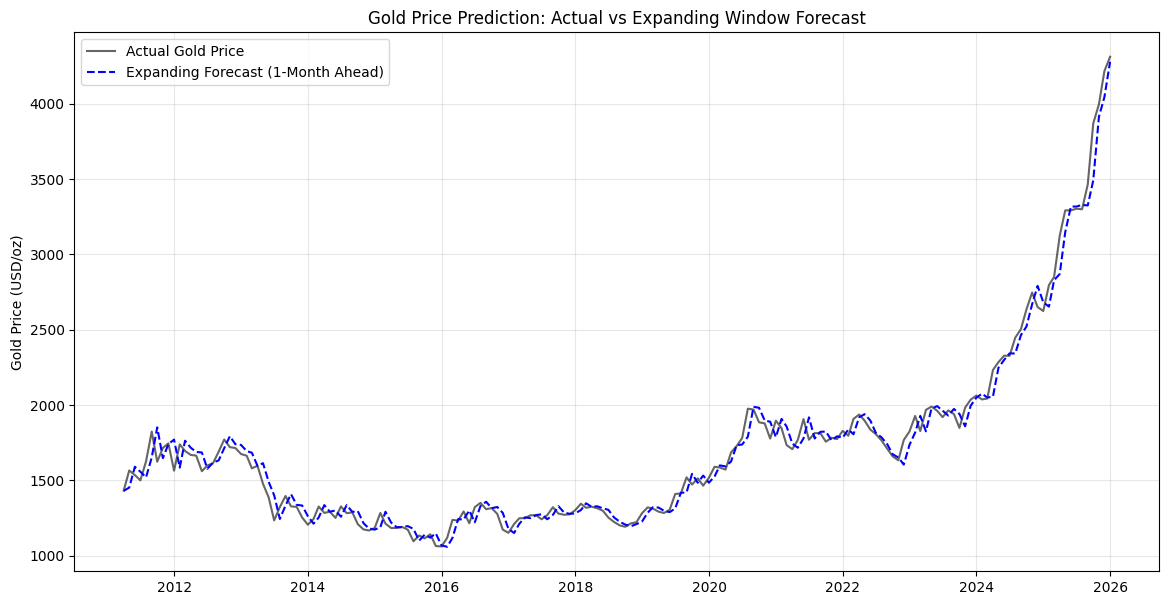

In [38]:
df_price_exp = pd.DataFrame(index=df_expanding.index)

df_price_exp['Actual_Price'] = data_model.loc[df_expanding.index, 'gold']

df_price_exp['Prev_Actual_Price'] = data_model['gold'].shift(1).loc[df_expanding.index]

df_price_exp['Forecast_Return'] = df_expanding['Forecast']
df_price_exp['Forecast_Price'] = df_price_exp['Prev_Actual_Price'] * np.exp(df_price_exp['Forecast_Return'])

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df_price_exp.index, df_price_exp['Actual_Price'], 
        label='Actual Gold Price', color='black', alpha=0.6, linewidth=1.5)
ax.plot(df_price_exp.index, df_price_exp['Forecast_Price'], 
        label='Expanding Forecast (1-Month Ahead)', color='blue', linestyle='--', linewidth=1.5)

ax.set_title('Gold Price Prediction: Actual vs Expanding Window Forecast')
ax.set_ylabel('Gold Price (USD/oz)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_locator(mdates.YearLocator(2)) # โชว์ปีทุกๆ 2 ปี
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

In [39]:
macro_daily_expanding = df_expanding[['Forecast']].copy()
macro_daily_expanding.columns = ['ols_macro_pred']
macro_daily_expanding

,ols_macro_pred
2011-03-31,0.013497
2011-04-30,0.013829
2011-05-31,0.015714
2011-06-30,0.014225
2011-07-31,0.013281
...,...
2025-08-31,0.007603
2025-09-30,0.007779
2025-10-31,0.011269
2025-11-30,0.011955


## Technical Variables Integration ##

In [40]:
macro_feature = df_expanding[['Forecast']].copy()
macro_feature.columns = ['Macro_Signal']

macro_daily = macro_feature.resample('D').asfreq()
macro_daily = macro_daily.fillna(method='ffill')
macro_daily

/var/folders/rc/w7r40l35143bxwkzfxdygctc0000gn/T/ipykernel_5262/1072878848.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_daily = macro_daily.fillna(method='ffill')


,Macro_Signal
2011-03-31,0.013497
2011-04-01,0.013497
2011-04-02,0.013497
2011-04-03,0.013497
2011-04-04,0.013497
...,...
2025-12-27,0.011955
2025-12-28,0.011955
2025-12-29,0.011955
2025-12-30,0.011955


In [41]:
df_daily = pd.read_csv('all_gold_data.csv', index_col=0, parse_dates=True)
df_daily.sort_index(inplace=True)
df_daily = df_daily[~df_daily.index.duplicated(keep='first')]

df_daily.ta.rsi(length=14, append=True) # Momentum
df_daily.ta.macd(fast=12, slow=26, signal=9, append=True) # Trend & Momentum
df_daily.ta.adx(length=14, append=True) # Trend Strength
df_daily.ta.cci(length=20, append=True) # Cyclical Trend
df_daily.ta.bbands(length=20, std=2, append=True) # Volatility
df_daily.ta.atr(length=14, append=True) # Volatility
df_daily.ta.ema(length=50, append=True)
df_daily.ta.ema(length=200, append=True)
df_daily['dist_ema50'] = (df_daily['close'] - df_daily['EMA_50']) / df_daily['EMA_50']
df_daily['dist_ema200'] = (df_daily['close'] - df_daily['EMA_200']) / df_daily['EMA_200']
df_daily['daily_range'] = (df_daily['high'] - df_daily['low']) / df_daily['open']

rolling_mean = df_daily['close'].rolling(window=20).mean()
rolling_std = df_daily['close'].rolling(window=20).std()
df_daily['z_score'] = (df_daily['close'] - rolling_mean) / rolling_std

cols_to_drop = [
    'EMA_50', 'EMA_200',      # เราใช้ dist_ema แทนแล้ว
    'BBU_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0' # เราใช้ bb_width กับ bb_percentage แทนแล้ว
]

cols_to_drop = [c for c in cols_to_drop if c in df_daily.columns]
df_daily.drop(columns=cols_to_drop, inplace=True)
df_daily.dropna(inplace=True)
df_daily

,open,high,low,close,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ADX_14,DMP_14,DMN_14,CCI_20_0.015,BBB_20_2.0,BBP_20_2.0,ATRr_14,dist_ema50,dist_ema200,daily_range,z_score
datetime,,,,,,,,,,,,,,,,,,,
1988-10-07,404.25000,404.25000,402.76001,402.76001,41.178135,-6.369532,1.282340,-7.651872,52.961653,18.826836,37.450245,-12.334036,9.168680,0.473850,3.572058,-0.032753,-0.090246,0.003686,-0.101952
1988-10-10,409.67001,409.67001,408.07001,408.07001,50.134207,-5.346589,1.844226,-7.190815,49.909434,26.548162,32.599317,42.011343,8.409289,0.646692,3.810483,-0.019231,-0.077533,0.003906,0.571911
1988-10-11,410.17001,410.17001,404.03000,404.03000,44.573522,-4.806489,1.907461,-6.713950,47.852237,23.620416,36.260498,29.467541,7.421808,0.559118,3.976878,-0.027838,-0.085878,0.014969,0.230486
1988-10-12,411.44000,411.44000,407.62000,407.62000,49.892117,-4.042177,2.137419,-6.179595,45.601093,22.807884,31.714853,74.803572,6.280292,0.738201,4.222101,-0.018461,-0.077041,0.009284,0.928678
1988-10-13,409.78000,409.78000,406.63000,406.63000,48.509716,-3.476266,2.162663,-5.638929,43.702109,21.569976,31.699315,74.928054,5.354902,0.757891,4.145522,-0.020044,-0.078556,0.007687,1.005446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-28,5099.19820,5329.23026,5098.86184,5327.17903,91.679427,185.534775,48.644043,136.890732,56.201451,59.674002,4.991645,171.520198,19.229419,1.113936,82.861464,0.162318,0.323272,0.045177,2.393561
2026-01-29,5326.98804,5597.22988,5122.53750,5310.53137,89.536686,201.161081,51.416279,149.744802,58.533568,58.690150,3.464801,170.118994,20.762581,1.006485,110.849386,0.151520,0.314961,0.089111,1.974641
2026-01-30,5308.49315,5451.71009,4706.06585,4940.66781,57.424586,181.606694,25.489514,156.117180,56.417632,38.677232,21.329118,66.098246,20.010023,0.617938,156.191876,0.068332,0.220665,0.140463,0.459808


In [42]:
df_final = macro_daily.join(df_daily, how='inner')
df_final['target_next_return'] = np.log(df_final['close']).diff().shift(-1)
df_final.dropna(inplace=True)

threshold = 0.005
conditions = [
    (df_final['target_next_return'] > threshold),
    (df_final['target_next_return'] < -threshold)
]

choices = [1, -1]
df_final['signal'] = np.select(conditions, choices, default=0)

df_final.to_csv('gold_technical.csv')
df_final

,Macro_Signal,open,high,low,close,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ADX_14,...,CCI_20_0.015,BBB_20_2.0,BBP_20_2.0,ATRr_14,dist_ema50,dist_ema200,daily_range,z_score,target_next_return,signal
2011-03-31,0.013497,1424.84998,1441.30005,1422.25000,1432.00000,58.075945,7.918749,-1.216544,9.135293,17.174878,...,68.680562,3.095770,0.714080,18.175059,0.020595,0.076966,0.013370,0.834637,-0.002531,0
2011-04-01,0.013497,1432.58997,1436.55005,1413.05005,1428.38000,56.097315,7.684745,-1.160439,8.845184,16.635577,...,24.694660,3.088470,0.633244,18.555412,0.017297,0.073450,0.016404,0.519482,0.005975,1
2011-04-04,0.013497,1428.73999,1438.93994,1427.79004,1436.93994,59.602194,8.096677,-0.598805,8.695482,16.278826,...,88.759255,3.147486,0.817676,18.026447,0.022455,0.079026,0.007804,1.238528,0.009806,1
2011-04-05,0.013497,1437.05005,1457.34998,1430.09998,1451.09998,64.632198,9.456722,0.608992,8.847730,16.933296,...,156.323432,3.580918,1.034950,18.685272,0.031215,0.088687,0.018962,2.085620,0.004401,0
2011-04-06,0.013497,1456.69995,1462.41003,1451.59998,1457.50000,66.653198,10.925058,1.661862,9.263196,17.776342,...,197.322154,4.121016,1.049514,18.158470,0.034313,0.092473,0.007421,2.142399,0.000686,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-26,0.011955,4479.62443,4550.78973,4476.55334,4523.58231,83.036726,81.614524,15.478790,66.135734,47.083832,...,168.583951,9.003712,0.982387,50.861782,0.069260,0.195293,0.016572,1.880692,0.002011,0
2025-12-27,0.011955,4523.48301,4534.74851,4522.15204,4532.69019,83.528717,85.487616,15.481506,70.006111,49.238648,...,150.856861,9.300016,0.946295,48.128545,0.068420,0.195348,0.002785,1.739978,-0.000023,0
2025-12-28,0.011955,4532.61899,4532.88130,4531.44651,4532.58587,83.498845,87.539551,14.026752,73.512799,51.239549,...,128.329053,9.244642,0.904088,44.793277,0.065538,0.193002,0.000317,1.575424,-0.044025,-1
2025-12-29,0.011955,4532.61769,4547.90835,4307.57154,4337.36579,48.525433,72.576478,-0.749056,73.325535,47.922290,...,18.659989,8.665716,0.399203,58.760672,0.018860,0.140013,0.053024,-0.392979,0.002153,0


## CNN

In [75]:
# Macro preparation
macro_for_cnn = pd.DataFrame(index=df_ret.index)
macro_for_cnn['macro_fed_change'] = df_ret['fed_change']

X_ols = sm.add_constant(df_ret[['fed_change']].shift(1))
macro_for_cnn['macro_resid'] = final_model.resid

# Merge with daily technical data
df_cnn = df_final.copy()

features_to_merge = ['macro_fed_change', 'macro_resid']
for col in features_to_merge:
    daily_macro = macro_for_cnn[col].resample('D').ffill()
    df_cnn[col] = daily_macro
df_cnn.dropna(inplace=True)

# df_cnn
df_cnn.columns

Index(['Macro_Signal', 'open', 'high', 'low', 'close', 'RSI_14',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'DMP_14',
       'DMN_14', 'CCI_20_0.015', 'BBB_20_2.0', 'BBP_20_2.0', 'ATRr_14',
       'dist_ema50', 'dist_ema200', 'daily_range', 'z_score',
       'target_next_return', 'signal', 'macro_fed_change', 'macro_resid'],
      dtype='object')

In [76]:
cnn_features = [
    'close', 'RSI_14', 'MACD_12_26_9', 'MACDs_12_26_9', 'ADX_14', 
    'CCI_20_0.015', 'ATRr_14', 'daily_range', 'z_score', 'dist_ema50',
    'Macro_Signal', 'macro_fed_change', 'macro_resid'
]

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = StandardScaler()

X_raw = df_cnn[cnn_features].values
y_raw = df_cnn[['target_next_return']].values # ทำนาย Return

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

def create_sequences(data_X, data_y, time_steps):
    Xs, ys = [], []
    for i in range(len(data_X) - time_steps):
        Xs.append(data_X[i:(i + time_steps)])
        ys.append(data_y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 20
X_cnn, y_cnn = create_sequences(X_scaled, y_scaled, TIME_STEPS)

# Train/Test (no Shuffle : Time Series)
# 80% Train, 20% Test
train_size = int(len(X_cnn) * 0.9)
X_train, X_test = X_cnn[:train_size], X_cnn[train_size:]
y_train, y_test = y_cnn[:train_size], y_cnn[train_size:]

print(f"Input Shape: {X_train.shape} (Samples, Time Steps, Features)")

Input Shape: (3510, 20, 13) (Samples, Time Steps, Features)


In [77]:
model_cnn = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    
    # --- Block 1: Short-term Patterns ---
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    # --- Block 2: Long-term Trends ---
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    # --- Interpretation ---
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3), # Prevent overfitting
    
    # --- Output ---
    Dense(32, activation='relu'),
    Dense(1, activation='linear') # Linear activation for regression
])

optimizer = Adam(learning_rate=0.001)
model_cnn.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model_cnn.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 20, 64)         │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,169 (278.00 KB)

 Trainable params: 70,785 (276.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [78]:
# Stop training if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6,
    verbose=1
)

history = model_cnn.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5506 - mae: 0.9137 - val_loss: 1.2477 - val_mae: 0.7599 - learning_rate: 0.0010
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0330 - mae: 0.7214 - val_loss: 1.2849 - val_mae: 0.7799 - learning_rate: 0.0010
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9818 - mae: 0.7082 - val_loss: 1.3011 - val_mae: 0.7957 - learning_rate: 0.0010
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9767 - mae: 0.7169 - val_loss: 1.2622 - val_mae: 0.7644 - learning_rate: 0.0010
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0262 - mae: 0.7207 - val_loss: 1.2519 - val_mae: 0.7622 - learning_rate: 0.0010
Epoch 6/100
 96/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9750 - mae: 0.7198
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9747 - mae: 0.7182 - val_loss: 1.2501 - val_mae: 0.7643 - learning_rate: 0.0

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


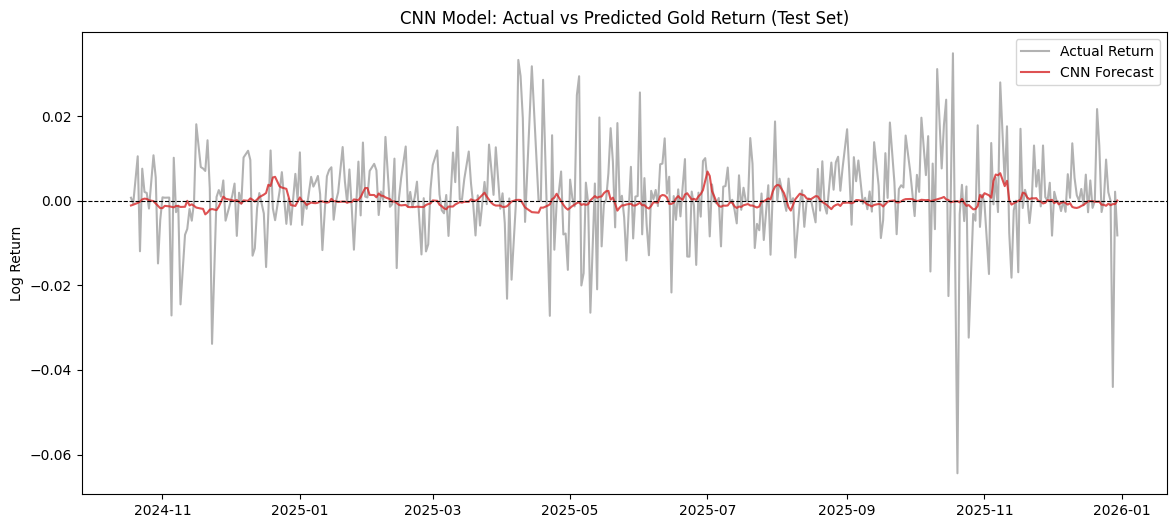

In [79]:
# Prediction
y_pred_scaled = model_cnn.predict(X_test)

# Inverse Transform (Back to real return values)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

test_start_idx = train_size + TIME_STEPS
dates = df_cnn.index[test_start_idx : test_start_idx + len(y_actual)]

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual Return', color='gray', alpha=0.6)
plt.plot(dates, y_pred, label='CNN Forecast', color='#D62728', alpha=0.8, linewidth=1.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Zero line
plt.title('CNN Model: Actual vs Predicted Gold Return (Test Set)')
plt.ylabel('Log Return')
plt.legend()

## CNN-LSTM

In [92]:
# --- 1. Model Architecture (Based on Livieris et al., 2020) ---
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])), # (20 Time Steps, n_features)
    
    # --- Part 1: CNN Layers (Feature Extraction) ---
    # Layer 1: สกัด Feature พื้นฐาน (32-64 Filters ในเปเปอร์ แต่เราอัดไป 64 เพื่อเก็บรายละเอียด Technical)
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    
    # Layer 2: สกัด Feature ที่ซับซ้อนขึ้น (128 Filters ตามเปเปอร์)
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    
    # Pooling: ย่อข้อมูลลงครึ่งหนึ่ง (เพื่อคัดเนื้อๆ เน้นๆ)
    MaxPooling1D(pool_size=2),
    
    # --- Part 2: LSTM Layer (Temporal Learning) ---
    # รับไม้ต่อจาก CNN เพื่อดู "ลำดับเวลา" ของ Feature ที่สกัดมาได้
    # (ในเปเปอร์ใช้ 200 units ซึ่งถือว่าใหญ่และดีสำหรับข้อมูลที่มีความซับซ้อน)
    LSTM(200, return_sequences=False, activation='tanh'),
    Dropout(0.3), # ป้องกันการจำข้อสอบ (Overfitting)
    
    # --- Part 3: Fully Connected (Interpretation) ---
    Dense(32, activation='relu'), # Hidden Layer ตามเปเปอร์
    
    # Output Layer (ทำนาย Return)
    Dense(1, activation='linear')
])

# --- 2. Optimizer & Compilation ---
# ใช้ Adam (มาตรฐานโลก) และ Loss เป็น MSE
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

# --- 3. Training ---
# ใช้ Callbacks เดิม (EarlyStopping, ReduceLR) เพราะดีอยู่แล้ว
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)              │ (None, 20, 64)         │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 20, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 200)            │       263,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,313 (1.13 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0766 - mae: 0.7449 - val_loss: 1.2967 - val_mae: 0.7952 - learning_rate: 0.0010
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9908 - mae: 0.7205 - val_loss: 1.2889 - val_mae: 0.7889 - learning_rate: 0.0010
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9728 - mae: 0.6943 - val_loss: 1.2379 - val_mae: 0.7503 - learning_rate: 0.0010
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9800 - mae: 0.7195 - val_loss: 1.2481 - val_mae: 0.7643 - learning_rate: 0.0010
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9465 - mae: 0.6991 - val_loss: 1.2396 - val_mae: 0.7532 - learning_rate: 0.0010
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9190 - mae: 0.6888 - val_loss: 1.2341 - val_mae: 0.7504 - learning_rate: 0.0010
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9401 - mae: 0.6919 - val_loss: 1.2318 - val_mae: 0.7514 - learning_rate: 0.00

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


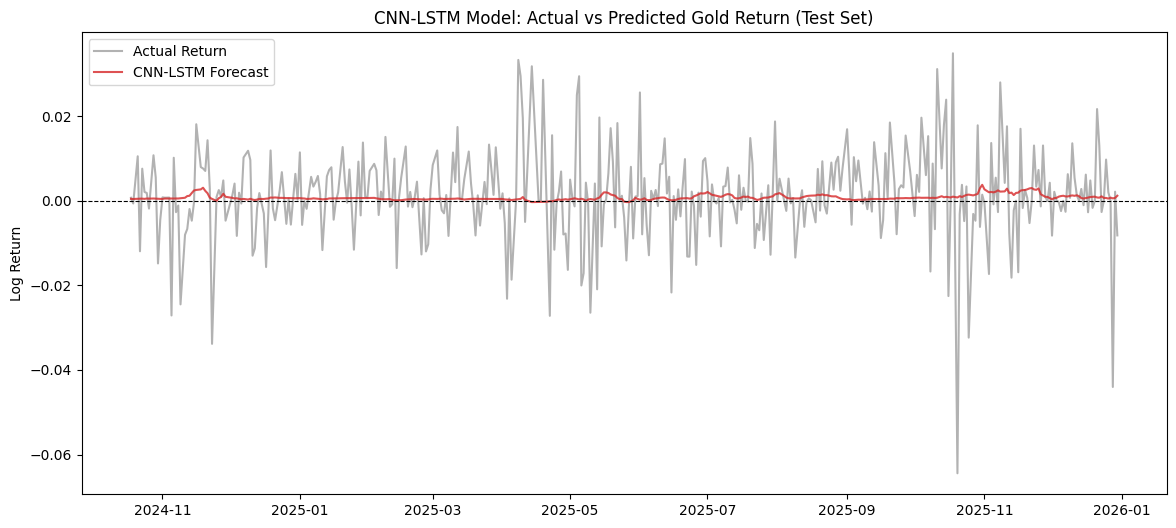

In [93]:
# Prediction
y_pred_scaled = model.predict(X_test)

# Inverse Transform (Back to real return values)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

test_start_idx = train_size + TIME_STEPS
dates = df_cnn.index[test_start_idx : test_start_idx + len(y_actual)]

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual Return', color='gray', alpha=0.6)
plt.plot(dates, y_pred, label='CNN-LSTM Forecast', color='#D62728', alpha=0.8, linewidth=1.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Zero line
plt.title('CNN-LSTM Model: Actual vs Predicted Gold Return (Test Set)')
plt.ylabel('Log Return')
plt.legend()

In [94]:
def evaluate_direction(model, X_test, y_test, scaler_y, model_name="Model"):
    """
    ฟังก์ชันสำหรับวัดความแม่นยำในการทายทิศทาง (ขึ้น/ลง)
    """
    # 1. ทำนายผล (ได้ค่าเป็น Return ที่ Scale มา)
    y_pred_scaled = model.predict(X_test, verbose=0)
    
    # 2. แปลงกลับเป็นค่าจริง (Real Return)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_actual = scaler_y.inverse_transform(y_test).flatten()
    
    # 3. แปลงเป็นทิศทาง (1 = ขึ้น/บวก, -1 = ลง/ลบ)
    # ใช้ np.sign: ถ้าค่า > 0 ได้ 1, ถ้า < 0 ได้ -1, ถ้า 0 ได้ 0
    pred_dir = np.sign(y_pred)
    actual_dir = np.sign(y_actual)
    
    # 4. คำนวณความแม่นยำ
    # ทายถูกคือเครื่องหมายเหมือนกัน (Correct Direction)
    correct_prediction = (pred_dir == actual_dir)
    accuracy = correct_prediction.mean() * 100
    
    # 5. แสดงผล
    print(f"📊 Directional Accuracy for {model_name}")
    print(f"{'-'*40}")
    print(f"✅ Accuracy: {accuracy:.2f}%")
    print(f"Count: Correct {correct_prediction.sum()} / Total {len(y_actual)}")
    
    # (Optional) Confusion Matrix: ดูว่าแม่นขาขึ้น หรือ ขาลง มากกว่ากัน
    # แปลง 1, -1 เป็น Label เพื่อให้อ่านง่าย
    labels = [1, -1]
    target_names = ['UP (Buy)', 'DOWN (Sell)']
    
    # หมายเหตุ: อาจต้องจัดการเคสที่เป็น 0 (ราคานิ่ง) โดยปัดเป็น 1 หรือ -1 หรือตัดทิ้ง
    # ในที่นี้ขอปัดเศษเล็กน้อยเพื่อเลี่ยง 0
    print("\n🔍 Detail Report:")
    # ใช้ classification_report ของ sklearn ช่วย
    # แปลงเป็น int เพื่อเข้าฟังก์ชัน
    pred_class = np.where(y_pred > 0, 1, -1)
    actual_class = np.where(y_actual > 0, 1, -1)
    
    print(classification_report(actual_class, pred_class, target_names=target_names))
    print(f"{'='*40}\n")
    
    return accuracy

In [95]:
# 1. เช็คของ CNN (สมมติว่า model ตัวปัจจุบันคือ CNN)
# acc_cnn = evaluate_direction(model_cnn, X_test, y_test, scaler_y, model_name="CNN Standalone")

# 2. เช็คของ CNN-LSTM (ถ้าคุณเทรนเสร็จแล้วและเก็บไว้ในตัวแปร model_lstm)
acc_lstm = evaluate_direction(model, X_test, y_test, scaler_y, model_name="CNN-LSTM")

📊 Directional Accuracy for CNN-LSTM
----------------------------------------
✅ Accuracy: 57.95%
Count: Correct 226 / Total 390

🔍 Detail Report:
              precision    recall  f1-score   support

    UP (Buy)       0.46      0.04      0.07       162
 DOWN (Sell)       0.59      0.97      0.73       228

    accuracy                           0.58       390
   macro avg       0.52      0.50      0.40       390
weighted avg       0.53      0.58      0.46       390


